In [119]:
#-------------------- ASSIGNMENT 3: HOUSE PRICES --------------------
#                  COMP3122 | KAILIE FIELD | 100627702
#                           15 November 2024
#--------------------------------------------------------------------

In [120]:
#---- [ IMPORTS ]
import numpy as np
import pandas as pd
import seaborn as sns
print(sns.__version__)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #--- this isnt integrated into my code
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

0.13.2


In [154]:
#---- [ LOADING DATASETS ]
house_train = pd.read_csv("train.csv")
house_test = pd.read_csv("test.csv")

#---- [ VERIFYING THERE IS NO NaN or INVALID DATA VALUES ]
salePrice_data = house_train['SalePrice'].describe()
missing_data = house_train['SalePrice'].isnull().sum()
invalid_data = house_train['SalePrice'][house_train['SalePrice'] <= 0]

#---- [VISUALIZING]
print("--------------- STATISTICAL DATA ---------------")
print(f"----------- PRESENT DATA VALUES: {salePrice_data['count']:.0f} ----------")
print("------------------------------------------------")
print(f"MIN: ${salePrice_data['min']:,.2f}")
print(f"MAX: ${salePrice_data['max']:,.2f}")
print(f"STD: ${salePrice_data['std']:,.2f}")
print(f"MEAN: ${salePrice_data['mean']:,.2f}")
print(f"----------- STATISTICAL DATA ---------------")
print(f"MISSING VALUE COUNT: {missing_data}")
print(f"INVALID VALUE COUNT (<= 0): {len(invalid_data)}")
print("------------------------------------------------")

--------------- STATISTICAL DATA ---------------
----------- PRESENT DATA VALUES: 1460 ----------
------------------------------------------------
MIN: $34,900.00
MAX: $755,000.00
STD: $79,442.50
MEAN: $180,921.20
----------- STATISTICAL DATA ---------------
MISSING VALUE COUNT: 0
INVALID VALUE COUNT (<= 0): 0
------------------------------------------------


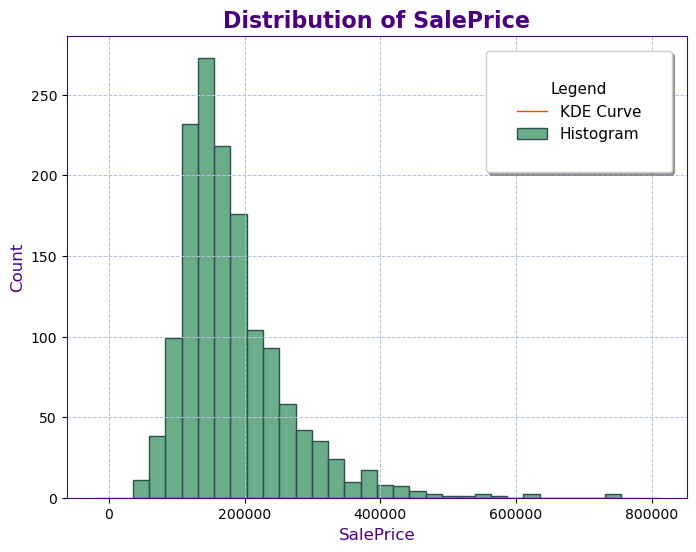

In [122]:
#---- [ STEP 1: VISUALIZING TARGET VARIABLE ]
#---- #2E8B57: Sea Green, #2F4F4F: Dark Edges, #4B0082: Indigo Labels, #B0C4DE: Light Steel Blue Grid, #4B0082': Indigo Spines

#---- visualizing
plt.figure(figsize=(8,6))
histogram = sns.histplot(house_train['SalePrice'], kde=False, bins=30, color='#2E8B57', edgecolor='#2F4F4F', alpha=0.7, label='Histogram')
kde = sns.kdeplot(house_train['SalePrice'], color='#FF4500', linewidth=1, label='KDE Curve')

plt.title('Distribution of SalePrice', fontsize=16, fontweight='bold', color='#4B0082')
plt.xlabel('SalePrice', fontsize=12, color='#4B0082')
plt.ylabel('Count', fontsize=12, color='#4B0082')
plt.grid(True, color='#B0C4DE', linestyle='--', linewidth=0.7)

for spine in plt.gca().spines.values():
    spine.set_color('#4B0082')

#---- Legend
plt.legend(loc='upper right', fontsize=11, title='Legend', title_fontsize=11, frameon=True, shadow=True, borderpad=2, borderaxespad=1)
    
plt.show()

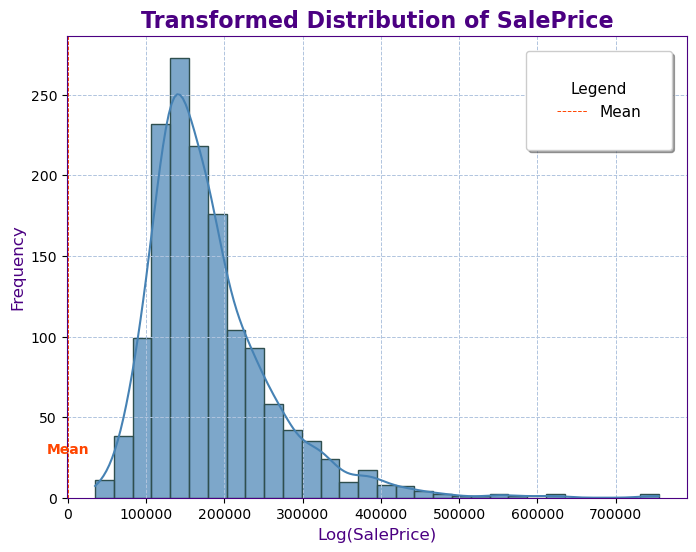

In [123]:
#---- [ APPLYING LOG TRANSFORMATIONS TO PREVENT SKEWNESS ]
#---- #4682B4: Blue Histogram, #2F4F4F: Orange Edges, #4B0082: Indigo Labels + Spine Values, #FF4500: Orange Mean Line
house_train['LogSalePrice'] = np.log(house_train['SalePrice'])

#---- visualizing the transformation
plt.figure(figsize=(8,6))

histogram2 = sns.histplot(house_train['SalePrice'], kde=True, bins=30, color='#4682B4', edgecolor='#2F4F4F', alpha=0.7)

#---- Title/Axis Labels
plt.title('Transformed Distribution of SalePrice', fontsize=16, fontweight='bold', color='#4B0082')
plt.xlabel('Log(SalePrice)', fontsize=12, color='#4B0082')
plt.ylabel('Frequency', fontsize=12, color='#4B0082')

#---- Highlighting Transformation using Annotations -- Focusing on the MEAN line
mean = house_train['LogSalePrice'].mean()
plt.text(mean, 30, 'Mean', color='#FF4500', fontweight='bold', ha='center', va='center')
plt.axvline(mean, color='#FF4500', linestyle='--', linewidth=0.7, label='Mean')

#---- Grid Styling
plt.grid(True, color='#B0C4DE', linestyle='--', linewidth=0.7)

#---- Frame Styling (Spines)
for spine in plt.gca().spines.values():
    spine.set_color('#4B0082')
    
#---- Legend
plt.legend(loc='upper right', fontsize=11, title='Legend', title_fontsize=11, frameon=True, shadow=True, borderpad=2, borderaxespad=1)

plt.show(histogram2)

In [171]:
#---- STEP 2: HANDLE MISSING VALUES FOR NUMERICAL FEATURES
train_numeric_features = house_train.select_dtypes(include=['number']).columns
test_numeric_features = [col for col in train_numeric_features if col in house_test.columns]

#---- fill missing values for numerical features with the mean of respective columns
house_train[train_numeric_features] = house_train[train_numeric_features].fillna(house_train[train_numeric_features].mean())
house_test[test_numeric_features] = house_test[test_numeric_features].fillna(house_test[test_numeric_features].mean())

#---- VISUALIZE UPDATED STATS FOR NUMERICAL FEATURES
bold = "\033[1m"
reset = "\033[0m"
salePrice_value = ['SalePrice']

statistical_display = {'mean', 'min', 'max', 'std'}
summary = house_train[train_numeric_features].describe()
#---- DISPLAYING IN READABLE FORMAT
print("--------------- TRAINING DATA [NUMERICAL FEATURES] ---------------")
print(f"Total Numerical Features: {house_train[train_numeric_features].shape[1]}")
print("------------------------------------------------------------------")

for stat in statistical_display:
    print(f"{bold}{stat.upper()} VALUES:{reset} ")
    for col in train_numeric_features:
        value = summary.loc[stat, col]
        if col == 'SalePrice':
            print(f"{col:15}{bold}${value:,.2f} <------ TARGET VARIABLE: {stat.upper()}")
        else:
            print(f"{col:15}: {value:,.2f}")
    print("------------------------------------------------------------------")

--------------- TRAINING DATA [NUMERICAL FEATURES] ---------------
Total Numerical Features: 38
------------------------------------------------------------------
MAX VALUES: 
Id             : 1,460.00
MSSubClass     : 190.00
LotFrontage    : 313.00
LotArea        : 215,245.00
OverallQual    : 10.00
OverallCond    : 9.00
YearBuilt      : 2,010.00
YearRemodAdd   : 2,010.00
MasVnrArea     : 1,600.00
BsmtFinSF1     : 5,644.00
BsmtFinSF2     : 1,474.00
BsmtUnfSF      : 2,336.00
TotalBsmtSF    : 6,110.00
1stFlrSF       : 4,692.00
2ndFlrSF       : 2,065.00
LowQualFinSF   : 572.00
GrLivArea      : 5,642.00
BsmtFullBath   : 3.00
BsmtHalfBath   : 2.00
FullBath       : 3.00
HalfBath       : 2.00
BedroomAbvGr   : 8.00
KitchenAbvGr   : 3.00
TotRmsAbvGrd   : 14.00
Fireplaces     : 3.00
GarageYrBlt    : 2,010.00
GarageCars     : 4.00
GarageArea     : 1,418.00
WoodDeckSF     : 857.00
OpenPorchSF    : 547.00
EnclosedPorch  : 552.00
3SsnPorch      : 508.00
ScreenPorch    : 480.00
PoolArea       : 738.0

In [125]:
#---- HANDLE MISSING VALUES FOR CATEGORY FEATURES
category_features_train = house_train.select_dtypes(exclude=['number']).columns
category_features_test = house_test.select_dtypes(exclude=['number']).columns

#---- fill missing values for category features with the mode
house_train[category_features_train] = house_train[category_features_train].fillna(house_train[category_features_train].mode().iloc[0])
house_test[category_features_test] = house_test[category_features_test].fillna(house_train[category_features_train].mode().iloc[0])

#---- VISUALIZE
print(house_train[category_features_train].describe())

       MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460  1460     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454  1419      925        1311      1459      1052   

       LandSlope Neighborhood Condition1  ... GarageType GarageFinish  \
count       1460         1460       1460  ...       1460         1460   
unique         3           25          9  ...          6            3   
top          Gtl        NAmes       Norm  ...     Attchd          Unf   
freq        1382          225       1260  ...        951          686   

       GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType  \
count        1460       1460       1460   1460   1460        1460     1460   
unique          5          5          3      3      4           4        9   
top            TA         TA      

In [126]:
#---- STEP 3: ONE-HOT ENCODING
house_train_encoded = pd.get_dummies(house_train, drop_first=True)
house_test_encoded = pd.get_dummies(house_test, drop_first=True)

#----ALIGNING COLUMNS
house_train_encoded, house_test_encoded = house_train_encoded.align(house_test_encoded, join='inner', axis=1)
print(house_train[category_features_train].describe())

       MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460  1460     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454  1419      925        1311      1459      1052   

       LandSlope Neighborhood Condition1  ... GarageType GarageFinish  \
count       1460         1460       1460  ...       1460         1460   
unique         3           25          9  ...          6            3   
top          Gtl        NAmes       Norm  ...     Attchd          Unf   
freq        1382          225       1260  ...        951          686   

       GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType  \
count        1460       1460       1460   1460   1460        1460     1460   
unique          5          5          3      3      4           4        9   
top            TA         TA      

In [127]:
#---- STEP 4: TRAINING
X_train = house_train_encoded.drop(columns=['LogSalePrice', 'SalePrice'], errors='ignore')
y_train = house_train['LogSalePrice']

#--- training continued
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [128]:
#---- STEP 5: PREDICTIONS
#---- reversing the log transformation
log_predictions = model.predict(house_test_encoded)
predictions = np.exp(log_predictions)
print(predictions)

[117391.35828637 128015.14166652 174991.88902633 ... 156026.755113
 115182.58879476 218131.68182675]


R-SQUARED (R2): 0.93
ROOT MEAN SQUARED: 470155116.45
MEAN SQUARED ERROR: 470155116.45
MEAN ABSOLUTE ERROR: 13281.39


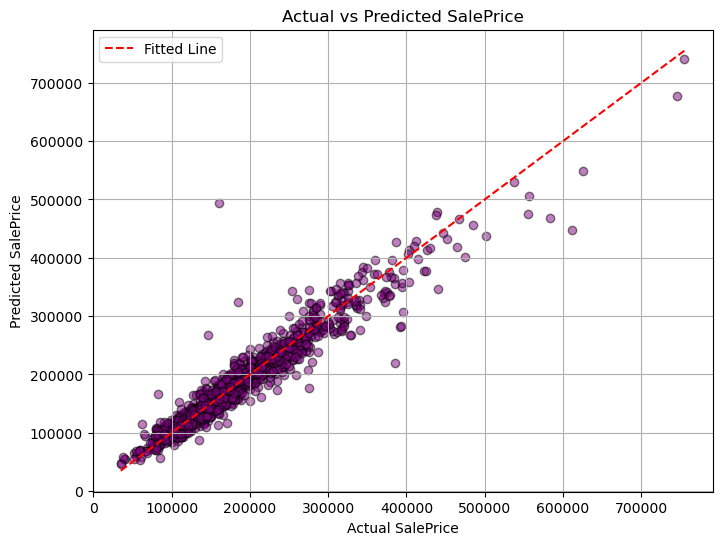

In [129]:
#---- STEP 6: EVALUATING MODEL

#---- Prediction on Training Data
log_y_train_pred = model.predict(X_train)
y_train_pred = np.exp(log_y_train_pred)

#---- REGRESSION METRICS
r2 = r2_score(house_train['SalePrice'], y_train_pred)
mean_squared = mean_squared_error(house_train['SalePrice'], y_train_pred)
mean_absolute = mean_absolute_error(house_train['SalePrice'], y_train_pred)
root_mean_squared = np.sqrt(mean_squared_error(house_train['SalePrice'], y_train_pred))

#---- VISUALIZING METRICS
print(f"R-SQUARED (R2): {r2:.2f}")
print(f"ROOT MEAN SQUARED: {mean_squared:.2f}")
print(f"MEAN SQUARED ERROR: {mean_squared:.2f}")
print(f"MEAN ABSOLUTE ERROR: {mean_absolute:.2f}")

#---- VISUALIZING ACTUAL VS. PREDICTED SALE PRICE
plt.figure(figsize=(8,6))
plt.scatter(house_train['SalePrice'], y_train_pred, alpha=0.5, color='purple', edgecolor='black')
plt.plot([house_train['SalePrice'].min(), house_train['SalePrice'].max()],
         [house_train['SalePrice'].min(), house_train['SalePrice'].max()],
         color='red', linestyle='--', label='Fitted Line')
plt.title('Actual vs Predicted SalePrice')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.legend()
plt.grid(True)
plt.show()

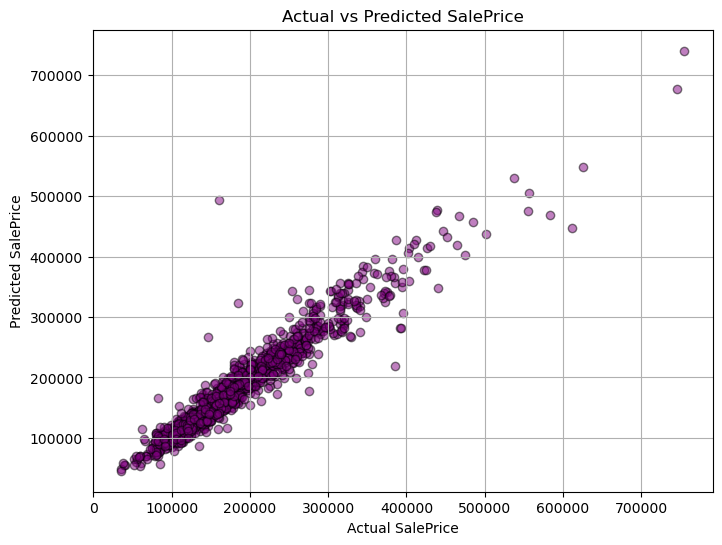

In [130]:
#---- FURTHER VISUALIZATIONS
plt.figure(figsize=(8,6))
plt.scatter(house_train['SalePrice'], y_train_pred, alpha=0.5, color='purple', edgecolor='k')
plt.title('Actual vs Predicted SalePrice')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.grid(True)
plt.show()

In [131]:
#---- STEP 7: AMALGAMATE TO SUBMISSION CSV
submission = pd.DataFrame({'Id': house_test['Id'], 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
#---- logging for personal update
print("---- COMPLETED SUCCESSFULLY")

---- COMPLETED SUCCESSFULLY
